# Original CvT-Model

<img src="./../CvT-Original.drawio.png?raw=1" alt="CvT-Modell mit Convolutional Embedding" title="CvT-Modell mit Convolutional Embedding" height="400" />

Dimensions sind ohne Batch-Size.

## Input-Dimensions

**Dimensions:** $H_0 = 64px, \quad W_0 = 64px, \quad C_0 = 3$ \
**Output-Shape:** `(3, 64, 64)`

## Conv2d

Berechnung Output-Dimensions:

$ \text{kernel size}\ k = 7, \quad \text{stride}\ s = 4, \quad \text{padding}\ p = 3 $ \
$ H_i = \frac{H_{i-1} + 2p - k}{s}\ + 1, \quad W_i = \frac{W_{i-1} + 2p - k}{s}\ + 1 $

**Output-Dimensions:** $H_1 = 16px, \quad W_1 = 16px, \quad C_1 = 64$ \
**Output-Shape:** `(64, 16, 16)`

## Flatten

**Output-Dimensions:** $H_1 W_1 \times C_1 = 16*16 \times 64$ \
**Output-Shape:** `(256, 64)`

## Conv Projection



## Multi-Head Attention

Berechnung der Query-, Key- und Value-Matrizen:

$X \in \mathbb{R}^{H_1 W_1 \times C_1}$ \
$d_k$ ist die Dimension der Value-, Query- und Key-Vektoren \
$W^Q, W^K, W^V \in \mathbb{R}^{C_1 \times d_k}$ \
$Q = XW^Q, \quad K = XW^K, \quad V = XW^V$

$d_k = 64$ \
$Q, K, V \in \mathbb{R}^{256 \times 64}$

**Output-Dimensions:** $256 \times 64$ \
**Output-Shape:** `(256, 64)`

## MLP

Expansion factor: $e = 4$

1. **Step:** Linear ➔ GELU ➔ Dropout
   
   **Output-Dimensions:** $256 \times 64 \times 4 = 256 \times 256$ \
   **Output-Shape:** `(256, 256)`

2. **Step:** Linear ➔ Dropout

    **Output-Dimensions:** $256 \times 256 \times 64 = 256 \times 64$ \
    **Output-Shape:** `(256, 64)`


# Imports

In [1]:
%pip install pytorch-lightning
%pip install torch torchvision
%pip install lightning
%pip install einops
%pip install timm
%pip install dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import torch
from einops import rearrange
import torch.nn as nn
from timm.models.layers import DropPath, trunc_normal_

IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

# Modell

In [3]:
class ConvEmbedding(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2)
        self.norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        # print('ConvEmbed.forward.0', x.shape)
        x = self.proj(x)
        # print('ConvEmbed.forward.1', x.shape)
        _, _, H, W = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        # print('ConvEmbed.forward.2', x.shape)
        x = self.norm(x)
        # print('ConvEmbed.forward.3', x.shape)
        return x, H, W

class ConvProjection(nn.Module):
    def __init__(self, dim, kernel_size, stride=1):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(dim, dim, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2, groups=dim)
        self.bn = nn.BatchNorm2d(dim)
        self.pointwise_conv = nn.Conv2d(dim, dim, kernel_size=1)

    def forward(self, x, H, W):
        # print('DepthwiseConvProjection.forward.0', x.shape)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)
        # print('DepthwiseConvProjection.forward.1', x.shape)
        x = self.depthwise_conv(x)
        x = self.bn(x)
        x = self.pointwise_conv(x)
        # print('DepthwiseConvProjection.forward.2', x.shape)
        x = rearrange(x, 'b c h w -> b (h w) c')
        # print('DepthwiseConvProjection.forward.3', x.shape)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=1, mlp_ratio=4.0, kernel_size=3):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.mlp_ratio = mlp_ratio

        self.norm1 = nn.LayerNorm(dim)
        self.proj_q_conv = ConvProjection(dim, kernel_size)
        self.proj_k_conv = ConvProjection(dim, kernel_size)
        self.proj_v_conv = ConvProjection(dim, kernel_size)

        self.proj_q = nn.Linear(dim, dim, bias=False)
        self.proj_k = nn.Linear(dim, dim, bias=False)
        self.proj_v = nn.Linear(dim, dim, bias=False)

        self.attn_drop = nn.Dropout(0.0)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(0.0)

        self.drop_path = DropPath(0.1)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(0.0),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(0.0)
        )

    def forward(self, x, H, W):
        residual = x
        x_norm = self.norm1(x)

        q = self.proj_q_conv(x_norm, H, W)
        k = self.proj_k_conv(x_norm, H, W)
        v = self.proj_v_conv(x_norm, H, W)

        q = rearrange(self.proj_q(q), 'b t (h d) -> b h t d', h=self.num_heads)
        k = rearrange(self.proj_k(k), 'b t (h d) -> b h t d', h=self.num_heads)
        v = rearrange(self.proj_v(v), 'b t (h d) -> b h t d', h=self.num_heads)

        attn_score = torch.einsum('bhlk,bhtk->bhlt', [q, k]) * self.scale
        attn = nn.functional.softmax(attn_score, dim=-1)
        attn = self.attn_drop(attn)

        x = torch.einsum('bhlt,bhtv->bhlv', [attn, v])
        x = rearrange(x, 'b h t d -> b t (h d)')

        x = self.proj(x)
        x = self.proj_drop(x)
        x = residual + self.drop_path(x)

        residual2 = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = residual2 + self.drop_path(x)
        return x

class CvTStage(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, depth, num_heads):
        super().__init__()
        self.embed = ConvEmbedding(in_ch, out_ch, kernel_size, stride)
        self.dropout = nn.Dropout(0.0)
        self.blocks = nn.ModuleList([
            TransformerBlock(out_ch, num_heads) for _ in range(depth)
        ])

    def forward(self, x):
        x, H, W = self.embed(x)
        x = self.dropout(x)
        for blk in self.blocks:
            x = blk(x, H, W)
        return x, H, W


class CvTOriginal(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.num_classes = num_classes
        self.stage1 = CvTStage(3, 64, kernel_size=5, stride=2, depth=1, num_heads=1)
        self.stage2 = CvTStage(64, 192, kernel_size=3, stride=2, depth=2, num_heads=3)
        self.stage3 = CvTStage(192, 384, kernel_size=3, stride=1, depth=10, num_heads=6)

        self.norm = nn.LayerNorm(384)
        self.head = nn.Linear(384, num_classes) 


    def forward(self, x):
        x1, H1, W1 = self.stage1(x)
        x1_spatial = rearrange(x1, 'b (h w) c -> b c h w', h=H1, w=W1)

        x2, H2, W2 = self.stage2(x1_spatial)
        x2_spatial = rearrange(x2, 'b (h w) c -> b c h w', h=H2, w=W2)

        x3, _, _ = self.stage3(x2_spatial)

        x = self.norm(x3)
        x = x.mean(dim=1)
        return self.head(x)

## Testing

In [4]:
model = CvTOriginal()

dummy_input = torch.randn(8, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (8, 200), f"Expected output shape (8, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)

dummy_input = torch.randn(1, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (1, 200), f"Expected output shape (1, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)


Model output shape is as expected: torch.Size([8, 200])
Model output shape is as expected: torch.Size([1, 200])


# Dataset

In [5]:
from models.processData import prepare_data_and_get_loaders

train_loader, val_loader, test_loader = prepare_data_and_get_loaders("/datasets/tiny-imagenet-200/tiny-imagenet-200.zip", "data/tiny-imagenet-200")

Data already extracted.


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


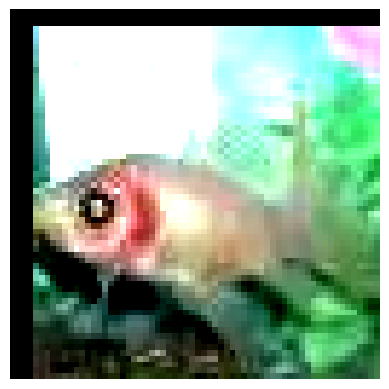

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

image, label = train_loader.dataset[0]
imshow(image)

# Training

In [ ]:
from models.trainModel import train_test_model

train_test_model(CvTOriginal, train_loader, val_loader, test_loader)

wandb: Currently logged in as: seya-schmassmann-fhnw. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seya-schmassmann-fhnw (wods). Use `wandb login --relogin` to force relogin


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CvTOriginal        | 28.8 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | train_f1  | MulticlassF1Score  | 0      | train
4 | val_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]